# Feedforward classification of the NMIST data
### Advanced Deep Learning 2024
This notebook was written originally Jon Sporring (mailto:sporring@di.ku.dk) and heavily inspired by https://clay-atlas.com/us/blog/2021/04/22/pytorch-en-tutorial-4-train-a-model-to-classify-mnist.

We consider the Modified National Institute of Standards and Technology database of handwritten digits (MNIST): http://yann.lecun.com/exdb/mnist/

In [31]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch

## Imports

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dset
from torchvision import datasets, transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Set global device

In [33]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cpu


## Functions

In [34]:
def training_loop(model, loss, optimizer, loader, epochs, verbose=True, device=device):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    """

    # Train
    for epoch in range(epochs):
        running_loss = 0.0

        for times, data in enumerate(loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.view(inputs.shape[0], -1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Foward + backward + optimize
            outputs = model(inputs)
            loss_tensor = loss(outputs, labels)
            loss_tensor.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss_tensor.item()
            if verbose:
                if times % 100 == 99 or times+1 == len(loader):
                    print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(loader), running_loss/2000))

In [35]:
def evaluate_model(model, loader, device=device):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.

    Returns: the total number of correct classifications,
             the total number of images
             the list of the per class correct classification,
             the list of the per class total number of images.
    """

    # Test
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.shape[0], -1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]

    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.view(inputs.shape[0], -1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    return (correct, total, class_correct, class_total)


## Main program

In [36]:
# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

In [37]:
# Data
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)
trainLoader = dset.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = dset.DataLoader(testSet, batch_size=64, shuffle=False)

# part 2: change the code below

Replace the code below with a convolutional neural network.

Text from problem statement:

Based on feedForwardMNIST.ipynb, make a new program CNNMNIST.ipynb where the feed-forward neural
network has been replaced with a convolutional neural network. The new network must also use:
Net(

    (main): Sequential(
    
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))

    (1): ReLU()

    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
    
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))

    (4): ReLU()

    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
    
    (6): Flatten(start_dim=1, end_dim=-1)
    
    (7): Linear(in_features=800, out_features=10, bias=True)
    
    (8): LogSoftmax(dim=1)
) )


## CNN model

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)), # 1*16*(3*3)+16 = 160
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)), # 16*32*(3*3)+32 = 4640
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(), 
            nn.Linear(in_features=800, out_features=10), # 800*10+10 = 8010
            nn.LogSoftmax(dim=1)

            # Total params: 160 + 4640 + 8010 = 12810
        )

    def forward(self, input):
        return self.main(input)

net = Net().to(device)
print(net)

total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Net(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=10, bias=True)
    (8): LogSoftmax(dim=1)
  )
)
Number of parameters: 12810


In [40]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainSet = MNIST(root='./data', train=True, download=True, transform=transform)
testSet = MNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders
trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False)

# Initialize the CNN model
net = Net()

# Parameters
epochs = 4
lr = 0.002
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

## Train

In [41]:
print('Training on %d images' % len(trainSet))
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for inputs, labels in trainLoader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(trainSet)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

print('Training Finished.\n')


Training on 60000 images


Epoch 1/4, Loss: 0.4810
Epoch 2/4, Loss: 0.1236
Epoch 3/4, Loss: 0.0918
Epoch 4/4, Loss: 0.0772
Training Finished.



## Test

In [42]:
# Test
correct = 0
total = 0
class_correct = [0 for _ in range(10)]
class_total = [0 for _ in range(10)]
net.eval()
with torch.no_grad():
    for inputs, labels in testLoader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

print('Accuracy of the network on the %d test images: %d %%' % (len(testSet), (100*correct / total)))
for i in range(10):
    print('Accuracy of %d: %.3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 98 %
Accuracy of 0: 0.993
Accuracy of 1: 0.992
Accuracy of 2: 0.990
Accuracy of 3: 0.976
Accuracy of 4: 0.986
Accuracy of 5: 0.988
Accuracy of 6: 0.979
Accuracy of 7: 0.957
Accuracy of 8: 0.970
Accuracy of 9: 0.968


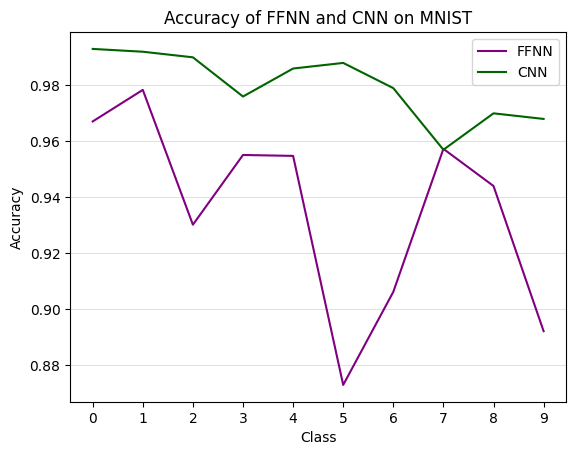

In [8]:
# Compare CNN with FFNN

FFNN_accs = [0.967105,0.978378,0.930233,0.955128,0.954802,0.873016,0.906250,0.957317,0.944056,0.892216]

CNN_accs = [0.993, 0.992, 0.990, 0.976, 0.986, 0.988, 0.979, 0.957, 0.970, 0.968]

import matplotlib.pyplot as plt

plt.plot(FFNN_accs, label='FFNN',color='purple')
plt.plot(CNN_accs, label='CNN',color='darkgreen')
plt.xlabel('Class')
plt.xticks(range(10))
plt.ylabel('Accuracy')
plt.title('Accuracy of FFNN and CNN on MNIST')
plt.grid(color = 'lightgray', linestyle = '-', linewidth = 0.5,axis='y')
plt.legend()